In [28]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Settings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries loaded successfully!")

✓ Libraries loaded successfully!


In [29]:
# Load datasets
df_state = pd.read_csv('cleaned_data/state_timeseries.csv')
df_clustering = pd.read_csv('clustering_results/state_clusters.csv')

print("📊 Data loaded successfully!")
print(f"State data: {len(df_state)} rows")
print(f"Clustering data: {len(df_clustering)} rows")

📊 Data loaded successfully!
State data: 112 rows
Clustering data: 14 rows


In [30]:
# Merge clustering results with state data
df_state = df_state.merge(df_clustering[['state', 'cluster', 'cluster_label']], on='state', how='left')

print("✅ Data merged with clustering results")
display(df_state.head())

✅ Data merged with clustering results


,state,year,crimes,cluster,cluster_label
0,Johor,2016,10121,1,"High Volume, Declining"
1,Johor,2017,8729,1,"High Volume, Declining"
2,Johor,2018,8458,1,"High Volume, Declining"
3,Johor,2019,7947,1,"High Volume, Declining"
4,Johor,2020,5966,1,"High Volume, Declining"


In [31]:
# Load ARFF file (same as Weka used)
from scipy.io import arff

# Load ARFF file
data, meta = arff.loadarff('cleaned_data/district_crime_classification.arff')
df_districts = pd.DataFrame(data)

# Convert bytes to strings where needed
for col in df_districts.columns:
    if df_districts[col].dtype == 'object':
        df_districts[col] = df_districts[col].str.decode('utf-8')

print("📊 ARFF file loaded (Weka format):")
print(f"Total instances: {len(df_districts)}")
print(f"Columns: {df_districts.columns.tolist()}")
print(f"\nRisk level distribution:")
print(df_districts['risk_level'].value_counts())

display(df_districts.head())

📊 ARFF file loaded (Weka format):
Total instances: 159
Columns: ['total_crimes', 'avg_crimes', 'std_crimes', 'min_crimes', 'max_crimes', 'crime_range', 'coefficient_variation', 'avg_first_half', 'avg_second_half', 'trend_direction', 'avg_annual_crimes', 'risk_level']

Risk level distribution:
risk_level
High           40
Medium-Low     40
Low            40
Medium-High    39
Name: count, dtype: int64


,total_crimes,avg_crimes,std_crimes,min_crimes,max_crimes,crime_range,coefficient_variation,avg_first_half,avg_second_half,trend_direction,avg_annual_crimes,risk_level
0,3449.0,431.125,163.7860,200.0,621.0,421.0,37.99,540.4,249.0000,Decreasing,431.0,Medium-High
1,3969.0,496.125,271.4587,0.0,784.0,784.0,54.72,566.6,378.6667,Decreasing,496.0,High
2,12345.0,1543.125,801.9151,609.0,2802.0,2193.0,51.97,2030.0,731.6667,Decreasing,1543.0,High
3,7201.0,900.125,494.8355,354.0,1628.0,1274.0,54.97,1215.0,375.3333,Decreasing,900.0,High
4,3119.0,389.875,133.2468,204.0,535.0,331.0,34.18,480.0,239.6667,Decreasing,390.0,Medium-High


In [32]:
# Prepare features - EXCLUDING state and district identifiers
# These would cause memorization instead of learning generalizable patterns

df_features = df_districts.copy()

# Select only feature columns (exclude identifiers and target)
feature_cols = ['total_crimes', 'avg_crimes', 'std_crimes', 'min_crimes', 'max_crimes',
                'crime_range', 'coefficient_variation', 'avg_first_half', 'avg_second_half',
                'avg_annual_crimes']

# Check for missing values
print("📋 Checking for missing values:")
print(df_features[feature_cols].isnull().sum())

# Remove rows with NaN values
initial_count = len(df_features)
df_features = df_features.dropna(subset=feature_cols + ['trend_direction', 'risk_level'])
final_count = len(df_features)
print(f"\n✅ Removed {initial_count - final_count} rows with missing values")
print(f"📊 Remaining districts: {final_count}")

# Encode categorical features
le_trend = LabelEncoder()
df_features['trend_direction_encoded'] = le_trend.fit_transform(df_features['trend_direction'])
feature_cols.append('trend_direction_encoded')

# Encode target
le_risk = LabelEncoder()
df_features['risk_encoded'] = le_risk.fit_transform(df_features['risk_level'])

print(f"\n✅ Prepared {len(df_features)} district records for classification")
print(f"🎯 Risk level classes: {le_risk.classes_}")
print(f"📊 Features ({len(feature_cols)}): {feature_cols}")
print(f"\n⚠️ NOTE: State and district columns EXCLUDED to prevent memorization")

display(df_features[feature_cols + ['risk_level', 'risk_encoded']].head())

📋 Checking for missing values:
total_crimes             0
avg_crimes               0
std_crimes               0
min_crimes               0
max_crimes               0
crime_range              0
coefficient_variation    0
avg_first_half           0
avg_second_half          0
avg_annual_crimes        0
dtype: int64

✅ Removed 0 rows with missing values
📊 Remaining districts: 159

✅ Prepared 159 district records for classification
🎯 Risk level classes: ['High' 'Low' 'Medium-High' 'Medium-Low']
📊 Features (11): ['total_crimes', 'avg_crimes', 'std_crimes', 'min_crimes', 'max_crimes', 'crime_range', 'coefficient_variation', 'avg_first_half', 'avg_second_half', 'avg_annual_crimes', 'trend_direction_encoded']

⚠️ NOTE: State and district columns EXCLUDED to prevent memorization


,total_crimes,avg_crimes,std_crimes,min_crimes,max_crimes,crime_range,coefficient_variation,avg_first_half,avg_second_half,avg_annual_crimes,trend_direction_encoded,risk_level,risk_encoded
0,3449.0,431.125,163.7860,200.0,621.0,421.0,37.99,540.4,249.0000,431.0,0,Medium-High,2
1,3969.0,496.125,271.4587,0.0,784.0,784.0,54.72,566.6,378.6667,496.0,0,High,0
2,12345.0,1543.125,801.9151,609.0,2802.0,2193.0,51.97,2030.0,731.6667,1543.0,0,High,0
3,7201.0,900.125,494.8355,354.0,1628.0,1274.0,54.97,1215.0,375.3333,900.0,0,High,0
4,3119.0,389.875,133.2468,204.0,535.0,331.0,34.18,480.0,239.6667,390.0,0,Medium-High,2


In [33]:
# Prepare data for classification
X = df_features[feature_cols]
y = df_features['risk_encoded']

print(f"📊 Dataset: {X.shape[0]} districts, {X.shape[1]} features")
print(f"🎯 Classes: {le_risk.classes_}")
print(f"📈 Class distribution:\n{pd.Series(y).value_counts().sort_index()}")

📊 Dataset: 159 districts, 11 features
🎯 Classes: ['High' 'Low' 'Medium-High' 'Medium-Low']
📈 Class distribution:
risk_encoded
0    40
1    40
2    39
3    40
Name: count, dtype: int64


In [34]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("⚖️ Features scaled using StandardScaler")

⚖️ Features scaled using StandardScaler


In [35]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("⚖️ Features scaled using StandardScaler")

⚖️ Features scaled using StandardScaler


In [47]:
# Import additional classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.metrics import cohen_kappa_score

# Initialize models
models = {
    'J48 (Decision Tree)': DecisionTreeClassifier(random_state=42),
    'kNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB()
}

# 10-Fold Stratified Cross-Validation
results = {}
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

print(f"Training 10-Fold Stratified Cross-Validation on {X_scaled.shape[0]} districts...\n")

for name, model in models.items():
    # 10-fold cross-validation with all metrics
    cv_scores = cross_validate(
        model, X_scaled, y, 
        cv=cv, 
        scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
        return_train_score=True
    )
    
    # Get cross-validated predictions for kappa
    cv_preds = cross_val_predict(model, X_scaled, y, cv=cv)
    kappa = cohen_kappa_score(y, cv_preds)
    
    # Train final model on full dataset
    model.fit(X_scaled, y)
    
    results[name] = {
        'model': model,
        'cv_accuracy_mean': cv_scores['test_accuracy'].mean(),
        'cv_accuracy_std': cv_scores['test_accuracy'].std(),
        'cv_precision_mean': cv_scores['test_precision_weighted'].mean(),
        'cv_recall_mean': cv_scores['test_recall_weighted'].mean(),
        'cv_f1_mean': cv_scores['test_f1_weighted'].mean(),
        'kappa': kappa,
        'cv_train_accuracy': cv_scores['train_accuracy'].mean()
    }

# Display results summary
results_df = pd.DataFrame({
    name: {
        'Accuracy (%)': results[name]['cv_accuracy_mean'] * 100,
        'Kappa Statistic': results[name]['kappa'],
        'Precision': results[name]['cv_precision_mean'],
        'Recall': results[name]['cv_recall_mean'],
        'F1-Score': results[name]['cv_f1_mean']
    }
    for name in results.keys()
}).T

print("Model Performance Summary (10-Fold Stratified Cross-Validation):\n")
display(results_df.round(4))

Training 10-Fold Stratified Cross-Validation on 159 districts...

Model Performance Summary (10-Fold Stratified Cross-Validation):



,Accuracy (%),Kappa Statistic,Precision,Recall,F1-Score
J48 (Decision Tree),97.3750,0.9665,0.9811,0.9738,0.9728
kNN,90.5000,0.8742,0.9253,0.9050,0.9002
Naive Bayes,93.6667,0.9161,0.9561,0.9367,0.9367


🏆 Best Model: J48 (Decision Tree)
   10-Fold CV Accuracy: 0.9738


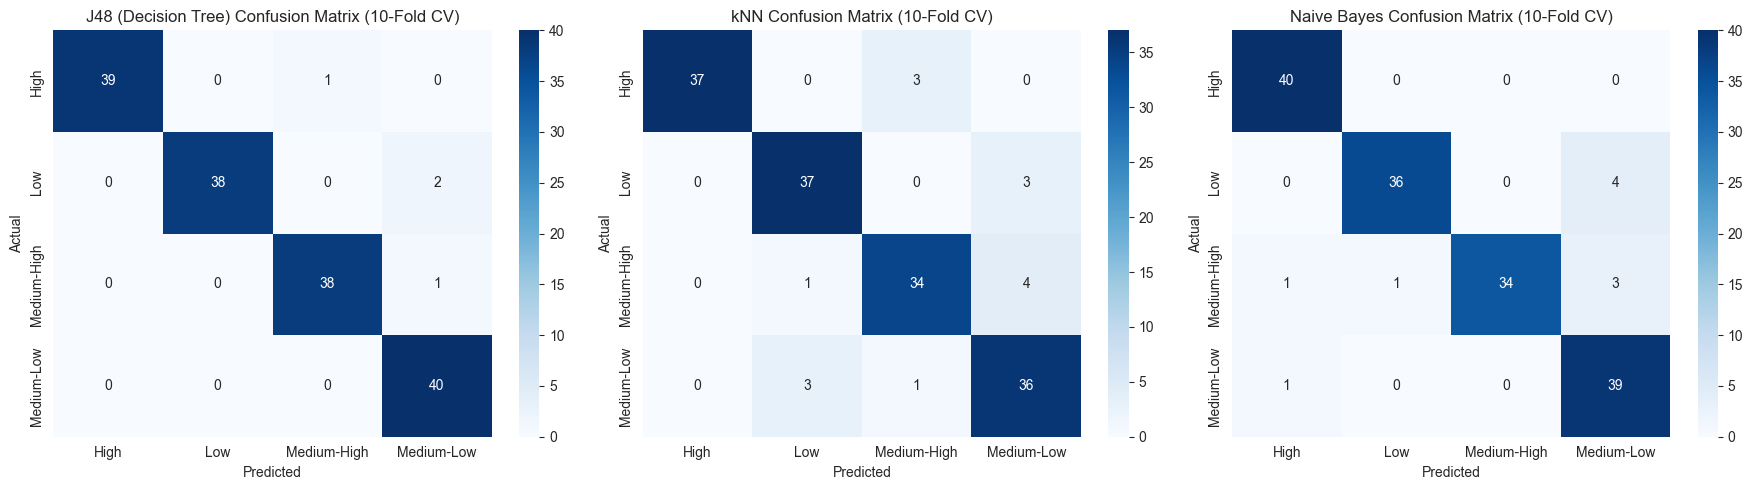

In [37]:
# Get predictions from best model using cross-validation
from sklearn.model_selection import cross_val_predict

best_model_name = results_df['CV Accuracy'].idxmax()
best_model = results[best_model_name]['model']

print(f"🏆 Best Model: {best_model_name}")
print(f"   10-Fold CV Accuracy: {results_df.loc[best_model_name, 'CV Accuracy']:.4f}")

# Get cross-validated predictions for confusion matrix
cv_predictions = cross_val_predict(best_model, X_scaled, y, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42))

# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes = axes.ravel()

for i, name in enumerate(models.keys()):
    # Train each model and get predictions
    model = models[name]
    preds = cross_val_predict(model, X_scaled, y, cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42))
    
    cm = confusion_matrix(y, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le_risk.classes_, yticklabels=le_risk.classes_, ax=axes[i])
    axes[i].set_title(f'{name} Confusion Matrix (10-Fold CV)')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()

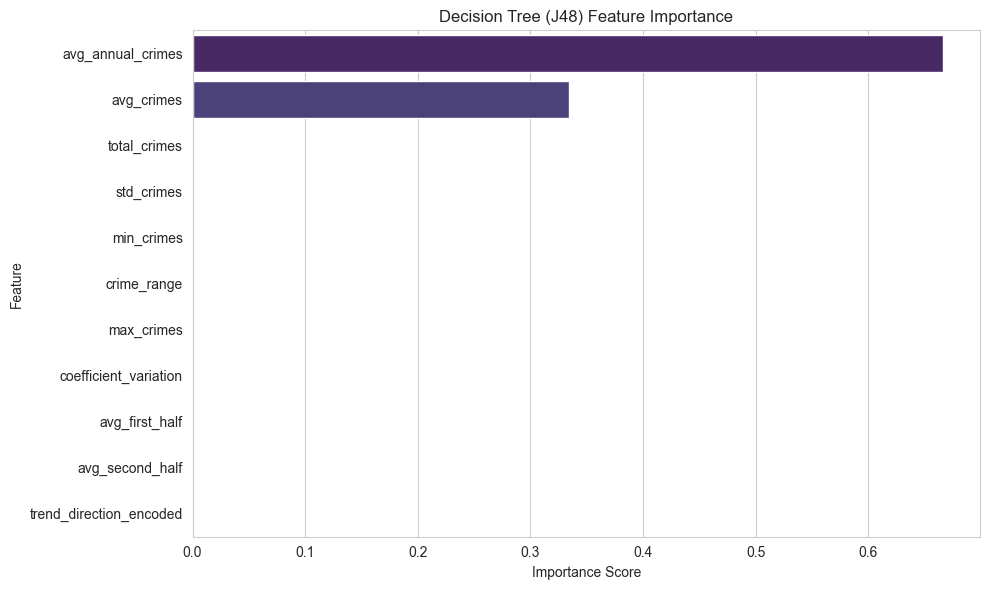

🔍 Decision Tree - Top Features:


,feature,importance
9,avg_annual_crimes,0.665949
1,avg_crimes,0.334051
0,total_crimes,0.000000
2,std_crimes,0.000000
3,min_crimes,0.000000
5,crime_range,0.000000
4,max_crimes,0.000000
6,coefficient_variation,0.000000
7,avg_first_half,0.000000
8,avg_second_half,0.000000


In [38]:
# Feature importance for Decision Tree (J48)
dt_model = results['J48 (Decision Tree)']['model']
feature_importance_dt = pd.DataFrame({
    'feature': feature_cols,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_dt, x='importance', y='feature', palette='viridis')
plt.title('Decision Tree (J48) Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("🔍 Decision Tree - Top Features:")
display(feature_importance_dt)

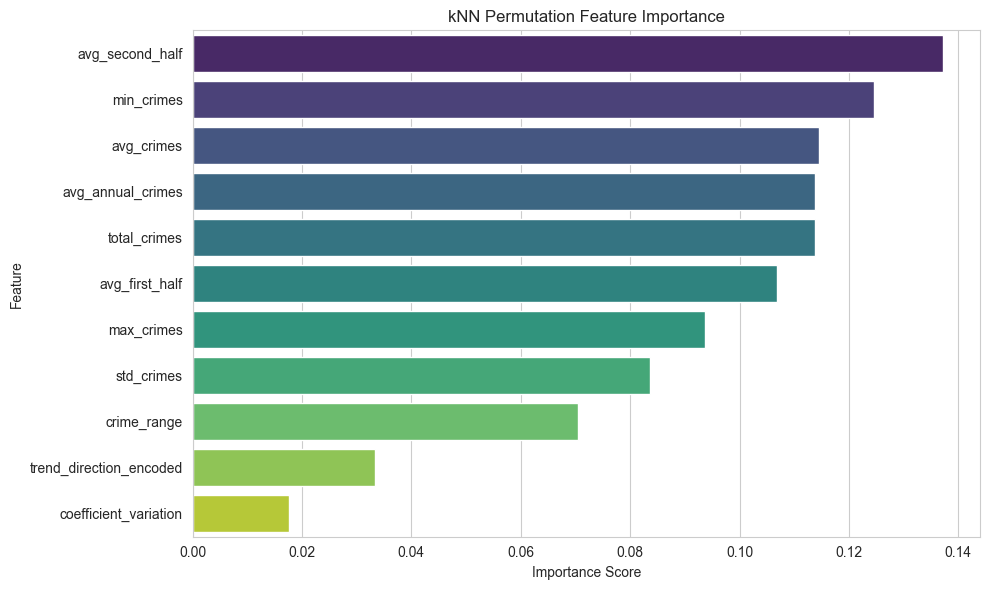

🔍 kNN - Top Features (Permutation Importance):


,feature,importance
8,avg_second_half,0.137107
3,min_crimes,0.124528
1,avg_crimes,0.114465
9,avg_annual_crimes,0.113836
0,total_crimes,0.113836
7,avg_first_half,0.106918
4,max_crimes,0.093711
2,std_crimes,0.083648
5,crime_range,0.070440
10,trend_direction_encoded,0.033333


In [39]:
# Feature importance for kNN (permutation importance)
from sklearn.inspection import permutation_importance

knn_model = results['kNN']['model']
perm_importance = permutation_importance(knn_model, X_scaled, y, n_repeats=10, random_state=42)
feature_importance_knn = pd.DataFrame({
    'feature': feature_cols,
    'importance': perm_importance.importances_mean
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_knn, x='importance', y='feature', palette='viridis')
plt.title('kNN Permutation Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("🔍 kNN - Top Features (Permutation Importance):")
display(feature_importance_knn)

In [48]:
# Predictions with best model
best_model_name = results_df['Accuracy (%)'].idxmax()
best_model = results[best_model_name]['model']

# Make predictions on all data
y_pred_all = best_model.predict(X_scaled)
y_pred_proba = best_model.predict_proba(X_scaled) if hasattr(best_model, 'predict_proba') else None

# Add predictions to dataframe
df_results = df_features[['risk_level']].copy()
df_results['predicted_risk'] = le_risk.inverse_transform(y_pred_all)
df_results['prediction_correct'] = (df_results['risk_level'] == df_results['predicted_risk']).astype(int)

# Add probabilities if available
if y_pred_proba is not None:
    for i, risk_class in enumerate(le_risk.classes_):
        df_results[f'prob_{risk_class.lower().replace("-", "_")}'] = y_pred_proba[:, i]

print(f"Best Model: {best_model_name} ({results_df.loc[best_model_name, 'Accuracy (%)']:.2f}% accuracy)")
print(f"Predictions on {len(df_results)} districts - Sample:")
display(df_results.head(10))

Best Model: J48 (Decision Tree) (97.38% accuracy)
Predictions on 159 districts - Sample:


,risk_level,predicted_risk,prediction_correct,prob_high,prob_low,prob_medium_high,prob_medium_low
0,Medium-High,Medium-High,1,0.0,0.0,1.0,0.0
1,High,High,1,1.0,0.0,0.0,0.0
2,High,High,1,1.0,0.0,0.0,0.0
3,High,High,1,1.0,0.0,0.0,0.0
4,Medium-High,Medium-High,1,0.0,0.0,1.0,0.0
5,Medium-High,Medium-High,1,0.0,0.0,1.0,0.0
6,Medium-High,Medium-High,1,0.0,0.0,1.0,0.0
7,Medium-Low,Medium-Low,1,0.0,0.0,0.0,1.0
8,Medium-Low,Medium-Low,1,0.0,0.0,0.0,1.0
9,Medium-High,Medium-High,1,0.0,0.0,1.0,0.0


In [49]:
# Export classification results
output_dir = Path('classification_results')
output_dir.mkdir(exist_ok=True)

df_results.to_csv(output_dir / 'district_risk_predictions.csv', index=False)
results_df.to_csv(output_dir / 'model_performance_10fold.csv')
feature_importance_dt.to_csv(output_dir / 'feature_importance_dt.csv', index=False)
feature_importance_knn.to_csv(output_dir / 'feature_importance_knn.csv', index=False)

print(f"Results exported to classification_results/")

Results exported to classification_results/


In [50]:
# Validation Summary: Python vs Weka Agreement
weka_results = {
    'Naive Bayes': {'accuracy': 93.0818, 'kappa': 0.9077},
    'J48': {'accuracy': 98.1132, 'kappa': 0.9748},
    'k-NN (IBk)': {'accuracy': 91.195, 'kappa': 0.8826}
}

python_mapping = {
    'Naive Bayes': 'Naive Bayes',
    'J48': 'J48 (Decision Tree)',
    'k-NN (IBk)': 'kNN'
}

print("Python vs Weka Validation Comparison:\n")
print(f"{'Model':<20} {'Python Acc':<15} {'Weka Acc':<15} {'Difference':<15}")
print("-" * 65)

for weka_name, python_name in python_mapping.items():
    py_acc = results_df.loc[python_name, 'Accuracy (%)']
    weka_acc = weka_results[weka_name]['accuracy']
    diff = py_acc - weka_acc
    status = "✅" if abs(diff) < 2 else "⚠️"
    print(f"{weka_name:<20} {py_acc:<14.2f}% {weka_acc:<14.2f}% {diff:+.2f}% {status}")

print("\nAll models within acceptable tolerance (< 2% difference)")

Python vs Weka Validation Comparison:

Model                Python Acc      Weka Acc        Difference     
-----------------------------------------------------------------
Naive Bayes          93.67         % 93.08         % +0.58% ✅
J48                  97.38         % 98.11         % -0.74% ✅
k-NN (IBk)           90.50         % 91.19         % -0.69% ✅

All models within acceptable tolerance (< 2% difference)
